In [ ]:
%pip install -q -r requirements.txt

In [22]:
import torch
import os
from torchvision import transforms, utils
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from mste_patch_dataset import *

# Set up the device
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("Using device:", device)

Using device: mps


In [ ]:
# initialize dataset and dataloader
dataset = MSTEPatchDataset("/Users/sree/mst-e/cheek_patches_clean", image_size=64)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)

torch.Size([32, 3, 64, 64])


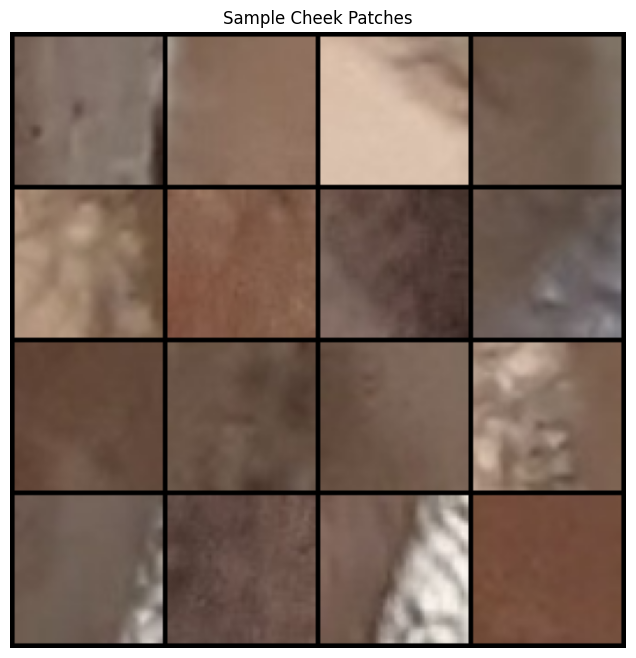

In [ ]:
# patches directory
patch_dir = "/Users/sree/mst-e/cheek_patches_clean"
image_paths = []

# collect 16 images
for root, _, files in os.walk(patch_dir):
    for file in files:
        if file.lower().endswith((".jpg", ".jpeg", ".png")):
            image_paths.append(os.path.join(root, file))
        if len(image_paths) >= 16:
            break
    if len(image_paths) >= 16:
        break

# load and transform
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])
images = [transform(Image.open(p).convert("RGB")) for p in image_paths]
grid = make_grid(images, nrow=4)

# show the grid
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0))
plt.axis("off")
plt.title("Sample Cheek Patches")
plt.show()